# A Quantum-Enhanced LSTM Layer

One field that so far has been poorly explored in Quantum Machine Learning is Natural Language Processing (NLP), the sub-field of Artificial Intelligence that gives computers the ability to read, write and to some extent comprehend written text. 

As documents are usually presented as sequences of words, historically one of the most successful techniques to manipulate this kind of data has been the Recurrent Neural Network architecture, and in particular a variant called Long Short-Term Memory (LSTM). LSTMs allowed machines to perform translations, classification and intent detection with state-of-the-art accuracy until the advent of Transformer networks. Still, it’s interesting at least from an educational point of view to dig into LSTMs to see what good quantum computing may bring to the field. For a more thorough discussion, please refer to “Quantum Long Short-Term Memory” by Chen, Yoo and Fang (arXiv:2009.01783) and “Recurrent Quantum Neural Networks” by J. Bausch (arXiv:2006.14619).

In [2]:
!pip install -r requirements.txt

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from qlstm import QLSTM

In [4]:
tag_to_ix = {"DET": 0, "NN": 1, "V": 2}  # Assign each tag with a unique index
ix_to_tag = {i:k for k,i in tag_to_ix.items()}

In [5]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

In [6]:
training_data = [
    # Tags are: DET - determiner; NN - noun; V - verb
    # For example, the word "The" is a determiner
    ("The dog ate the apple".split(), ["DET", "NN", "V", "DET", "NN"]),
    ("Everybody read that book".split(), ["NN", "V", "DET", "NN"])
]
word_to_ix = {}

# For each words-list (sentence) and tags-list in each tuple of training_data
for sent, tags in training_data:
    for word in sent:
        if word not in word_to_ix:  # word has not been assigned an index yet
            word_to_ix[word] = len(word_to_ix)  # Assign each word with a unique index

print(f"Vocabulary: {word_to_ix}")
print(f"Entities: {ix_to_tag}")

Vocabulary: {'The': 0, 'dog': 1, 'ate': 2, 'the': 3, 'apple': 4, 'Everybody': 5, 'read': 6, 'that': 7, 'book': 8}
Entities: {0: 'DET', 1: 'NN', 2: 'V'}


In [7]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size, n_qubits=0):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        if n_qubits > 0:
            print("Tagger will use Quantum LSTM")
            self.lstm = QLSTM(embedding_dim, hidden_dim, n_qubits=n_qubits)
        else:
            print("Tagger will use Classical LSTM")
            self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_logits = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_logits, dim=1)
        return tag_scores

In [8]:
embedding_dim = 8
hidden_dim = 6
n_epochs = 300

In [9]:
model_classical = LSTMTagger(embedding_dim, 
                        hidden_dim, 
                        vocab_size=len(word_to_ix), 
                        tagset_size=len(tag_to_ix), 
                        n_qubits=0)

Tagger will use Classical LSTM


## Training

In [16]:
def train(model, n_epochs):
    loss_function = nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1)

    history = {
        'loss': []
    }
    for epoch in range(n_epochs):
        losses = []
        for sentence, tags in training_data:
            # Step 1. Remember that Pytorch accumulates gradients.
            # We need to clear them out before each instance
            model.zero_grad()

            # Step 2. Get our inputs ready for the network, that is, turn them into
            # Tensors of word indices.
            sentence_in = prepare_sequence(sentence, word_to_ix)
            targets = prepare_sequence(tags, tag_to_ix)

            # Step 3. Run our forward pass.
            tag_scores = model(sentence_in)

            # Step 4. Compute the loss, gradients, and update the parameters by
            #  calling optimizer.step()
            loss = loss_function(tag_scores, targets)
            loss.backward()
            optimizer.step()
            losses.append(float(loss))
        avg_loss = np.mean(losses)
        history['loss'].append(avg_loss)
        print("Epoch {} / {}: Loss = {:.3f}".format(epoch+1, n_epochs, avg_loss))
    return history

In [17]:
history_classical = train(model_classical, n_epochs)

Epoch 1 / 300: Loss = 1.075
Epoch 2 / 300: Loss = 1.073
Epoch 3 / 300: Loss = 1.071
Epoch 4 / 300: Loss = 1.069
Epoch 5 / 300: Loss = 1.067
Epoch 6 / 300: Loss = 1.065
Epoch 7 / 300: Loss = 1.063
Epoch 8 / 300: Loss = 1.061
Epoch 9 / 300: Loss = 1.060
Epoch 10 / 300: Loss = 1.058
Epoch 11 / 300: Loss = 1.056
Epoch 12 / 300: Loss = 1.054
Epoch 13 / 300: Loss = 1.052
Epoch 14 / 300: Loss = 1.050
Epoch 15 / 300: Loss = 1.048
Epoch 16 / 300: Loss = 1.046
Epoch 17 / 300: Loss = 1.044
Epoch 18 / 300: Loss = 1.042
Epoch 19 / 300: Loss = 1.040
Epoch 20 / 300: Loss = 1.038
Epoch 21 / 300: Loss = 1.036
Epoch 22 / 300: Loss = 1.034
Epoch 23 / 300: Loss = 1.031
Epoch 24 / 300: Loss = 1.029
Epoch 25 / 300: Loss = 1.027
Epoch 26 / 300: Loss = 1.024
Epoch 27 / 300: Loss = 1.022
Epoch 28 / 300: Loss = 1.019
Epoch 29 / 300: Loss = 1.017
Epoch 30 / 300: Loss = 1.014
Epoch 31 / 300: Loss = 1.012
Epoch 32 / 300: Loss = 1.009
Epoch 33 / 300: Loss = 1.006
Epoch 34 / 300: Loss = 1.003
Epoch 35 / 300: Loss = 

Epoch 278 / 300: Loss = 0.036
Epoch 279 / 300: Loss = 0.036
Epoch 280 / 300: Loss = 0.036
Epoch 281 / 300: Loss = 0.036
Epoch 282 / 300: Loss = 0.035
Epoch 283 / 300: Loss = 0.035
Epoch 284 / 300: Loss = 0.035
Epoch 285 / 300: Loss = 0.035
Epoch 286 / 300: Loss = 0.034
Epoch 287 / 300: Loss = 0.034
Epoch 288 / 300: Loss = 0.034
Epoch 289 / 300: Loss = 0.034
Epoch 290 / 300: Loss = 0.034
Epoch 291 / 300: Loss = 0.033
Epoch 292 / 300: Loss = 0.033
Epoch 293 / 300: Loss = 0.033
Epoch 294 / 300: Loss = 0.033
Epoch 295 / 300: Loss = 0.033
Epoch 296 / 300: Loss = 0.032
Epoch 297 / 300: Loss = 0.032
Epoch 298 / 300: Loss = 0.032
Epoch 299 / 300: Loss = 0.032
Epoch 300 / 300: Loss = 0.032


In [18]:
def print_result(model):
    with torch.no_grad():
        input_sentence = training_data[0][0]
        labels = training_data[0][1]
        inputs = prepare_sequence(input_sentence, word_to_ix)
        tag_scores = model(inputs)

        tag_ids = torch.argmax(tag_scores, dim=1).numpy()
        tag_labels = [ix_to_tag[k] for k in tag_ids]
        print(f"Sentence:  {input_sentence}")
        print(f"Labels:    {labels}")
        print(f"Predicted: {tag_labels}")

In [19]:
print_result(model_classical)

Sentence:  ['The', 'dog', 'ate', 'the', 'apple']
Labels:    ['DET', 'NN', 'V', 'DET', 'NN']
Predicted: ['DET', 'NN', 'V', 'DET', 'NN']


In [20]:
n_qubits = 4

model_quantum = LSTMTagger(embedding_dim, 
                        hidden_dim, 
                        vocab_size=len(word_to_ix), 
                        tagset_size=len(tag_to_ix), 
                        n_qubits=n_qubits)

Tagger will use Quantum LSTM
weight_shapes = (n_qlayers, n_qubits) = (1, 4)


In [27]:
history_quantum = train(model_quantum, n_epochs)

Epoch 1 / 300: Loss = 1.051
Epoch 2 / 300: Loss = 1.049
Epoch 3 / 300: Loss = 1.048
Epoch 4 / 300: Loss = 1.046
Epoch 5 / 300: Loss = 1.044
Epoch 6 / 300: Loss = 1.043
Epoch 7 / 300: Loss = 1.041
Epoch 8 / 300: Loss = 1.040
Epoch 9 / 300: Loss = 1.038
Epoch 10 / 300: Loss = 1.037
Epoch 11 / 300: Loss = 1.035
Epoch 12 / 300: Loss = 1.033
Epoch 13 / 300: Loss = 1.031
Epoch 14 / 300: Loss = 1.030
Epoch 15 / 300: Loss = 1.028
Epoch 16 / 300: Loss = 1.026
Epoch 17 / 300: Loss = 1.024
Epoch 18 / 300: Loss = 1.021
Epoch 19 / 300: Loss = 1.019
Epoch 20 / 300: Loss = 1.017
Epoch 21 / 300: Loss = 1.014
Epoch 22 / 300: Loss = 1.011
Epoch 23 / 300: Loss = 1.008
Epoch 24 / 300: Loss = 1.005
Epoch 25 / 300: Loss = 1.002
Epoch 26 / 300: Loss = 0.999
Epoch 27 / 300: Loss = 0.995
Epoch 28 / 300: Loss = 0.991
Epoch 29 / 300: Loss = 0.987
Epoch 30 / 300: Loss = 0.983
Epoch 31 / 300: Loss = 0.979
Epoch 32 / 300: Loss = 0.974
Epoch 33 / 300: Loss = 0.969
Epoch 34 / 300: Loss = 0.964
Epoch 35 / 300: Loss = 

Epoch 278 / 300: Loss = 0.112
Epoch 279 / 300: Loss = 0.111
Epoch 280 / 300: Loss = 0.110
Epoch 281 / 300: Loss = 0.110
Epoch 282 / 300: Loss = 0.109
Epoch 283 / 300: Loss = 0.108
Epoch 284 / 300: Loss = 0.107
Epoch 285 / 300: Loss = 0.106
Epoch 286 / 300: Loss = 0.105
Epoch 287 / 300: Loss = 0.104
Epoch 288 / 300: Loss = 0.104
Epoch 289 / 300: Loss = 0.103
Epoch 290 / 300: Loss = 0.102
Epoch 291 / 300: Loss = 0.101
Epoch 292 / 300: Loss = 0.100
Epoch 293 / 300: Loss = 0.100
Epoch 294 / 300: Loss = 0.099
Epoch 295 / 300: Loss = 0.098
Epoch 296 / 300: Loss = 0.097
Epoch 297 / 300: Loss = 0.097
Epoch 298 / 300: Loss = 0.096
Epoch 299 / 300: Loss = 0.095
Epoch 300 / 300: Loss = 0.094


In [28]:
print_result(model_quantum)

Sentence:  ['The', 'dog', 'ate', 'the', 'apple']
Labels:    ['DET', 'NN', 'V', 'DET', 'NN']
Predicted: ['DET', 'NN', 'V', 'DET', 'NN']


In [29]:
from matplotlib import pyplot as plt

def plot_history(history_classical, history_quantum):
    loss_c = history_classical['loss']
    loss_q = history_quantum['loss']
    n_epochs = max([len(loss_c), len(loss_q)])
    x_epochs = [i for i in range(n_epochs)]
    
    plt.figure(figsize=(6, 4))
    plt.plot(loss_c, label="Classical LSTM")
    plt.plot(loss_q, label="Quantum LSTM")
    plt.title("POS Tagger Training")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.ylim(0., 1.5)
    plt.legend(loc="upper right")

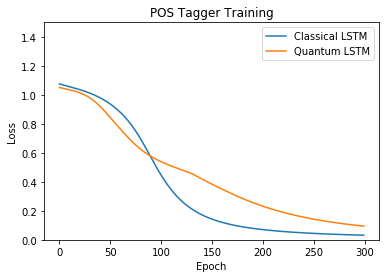

In [30]:
plot_history(history_classical, history_quantum)